In [38]:
setwd('/Users/alexis/IEHS Dropbox/Rager Lab/Alexis_Payton/4_Compartment_Analysis_2021/Expt1.1_Cluster Distribution Analyses/Input')
Output = ('/Users/alexis/IEHS Dropbox/Rager Lab/Alexis_Payton/4_Compartment_Analysis_2021/Expt1.1_Cluster Distribution Analyses/Output')
cur_date = "040921"

library(readxl)
library(data.table)
library(factoextra)
library(dplyr)
library(tidyverse)
library(gridExtra)
library(cluster)
library(vegan)
library(fpc)
library(ggdendro)
library(NbClust)
library(ggrepel)


#reading in file
cytokines <- data.frame(read_excel("CytokineData_032521.xlsx", sheet = 2))

#reading in demographics file
subjects = data.frame(read_excel("SubjectInfo_032521.xlsx", sheet = 2))

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



This is an analysis to determine how baseline cytokines cluster (using k means) and to get their corresponding eigencytokines by compartment. Want to get clusters that are similar to those in previous dataset. 

In [39]:
#either pivot wider or dcast works
#cytokines %>%
    #filter(Group == 'NS') %>%
    #select(-Compartment, -SubjectNo, -Conc, -Group) %>%
    #pivot_wider(names_from = Protein, values_from = Conc_pslog2)

#changing format of df
cytokines = cytokines %>% 
    #only want non-smokers for baseline analysis 
    filter(Group == 'NS') %>% 
    #background filter eliminating any cytokines that are not expressed
    mutate(ifelse(Conc_pslog2 == 0, NA, Conc_pslog2))
cytokines = reshape2::dcast(cytokines, SubjectID ~ Protein, value.var = "Conc_pslog2") %>% 
    column_to_rownames("SubjectID") 

#Z-score normalizing across cytokines within each compartment (using pseudolog2 of concentrations)
# the scale function operates across columns 
cytokines_scaled <- cytokines %>% 
  scale() %>% 
  as.data.frame()

In [ ]:
#Export non-normalized data for each compartment 
write.csv(cytokines, paste0(Output,"/", cur_date, "cytokines_NonNorm.csv"), row.names = TRUE)

#Export scaled data for each compartment
write.csv(cytokines_scaled, paste0(Output,"/", cur_date, "cytokines_Scaled.csv"), row.names = TRUE)

# Baseline Clusters

First, we can estimate the optimal number of clusters, as described in:
- https://afit-r.github.io/kmeans_clustering
- https://www.datanovia.com/en/lessons/k-means-clustering-in-r-algorith-and-practical-examples/
- https://www.datanovia.com/en/lessons/determining-the-optimal-number-of-clusters-3-must-know-methods/

> - Compute k-means clustering using different values of clusters k
> - Next, the wss (within sum of square) is drawn according to the number of clusters
> - The location of a bend (knee) in the plot is generally considered as an indicator of the appropriate number of clusters.
> - The R function fviz_nbclust() [in factoextra package] provides a convenient solution to estimate the optimal number of clusters.

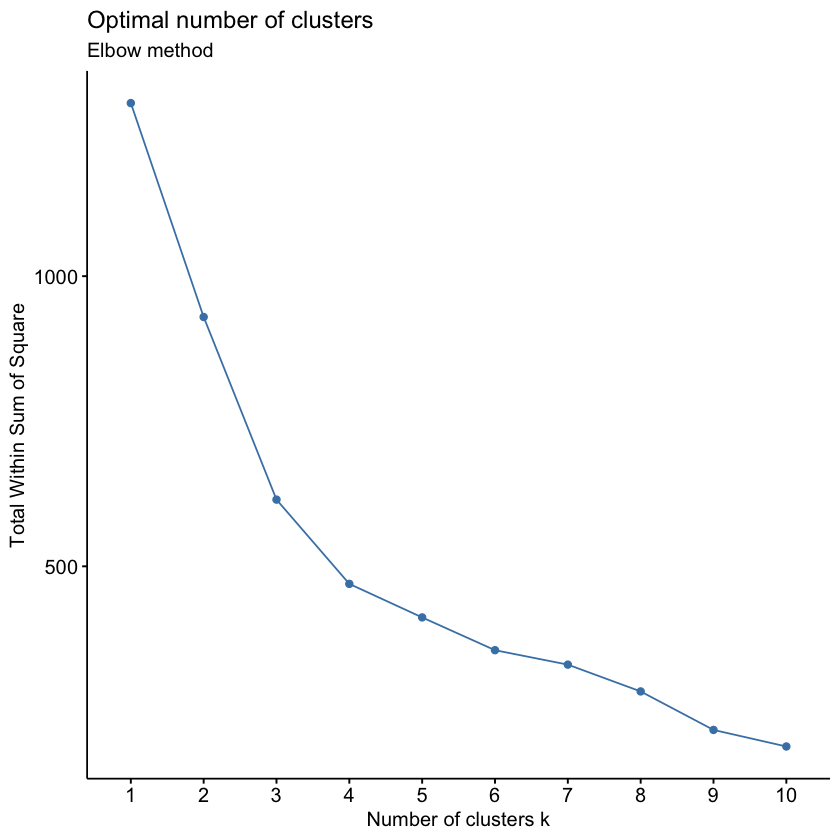

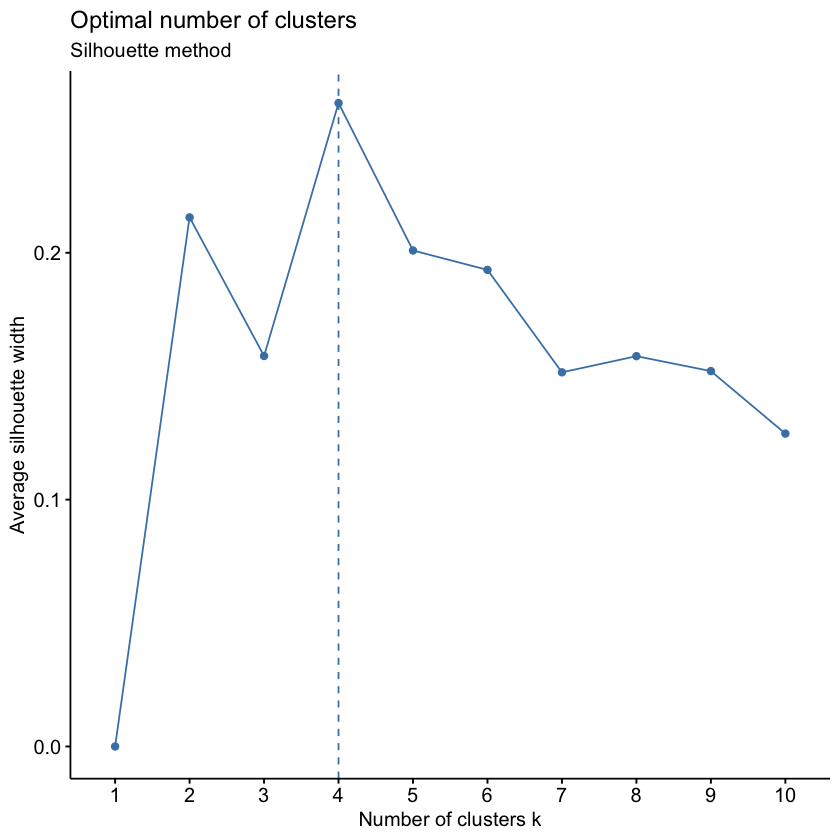

In [40]:
fviz_nbclust(cytokines, kmeans, method = "wss") +
# The generated plot represents the variance within the clusters. It decreases as k increases, but it can be seen a bend (or “elbow”) at k = 4
  labs(subtitle = "Elbow method") # suggests 4
fviz_nbclust(cytokines, kmeans, method = "silhouette") + 
  labs(subtitle="Silhouette method") # suggests 4 

Run the cluster code using the identified number of clusters for subjects first.

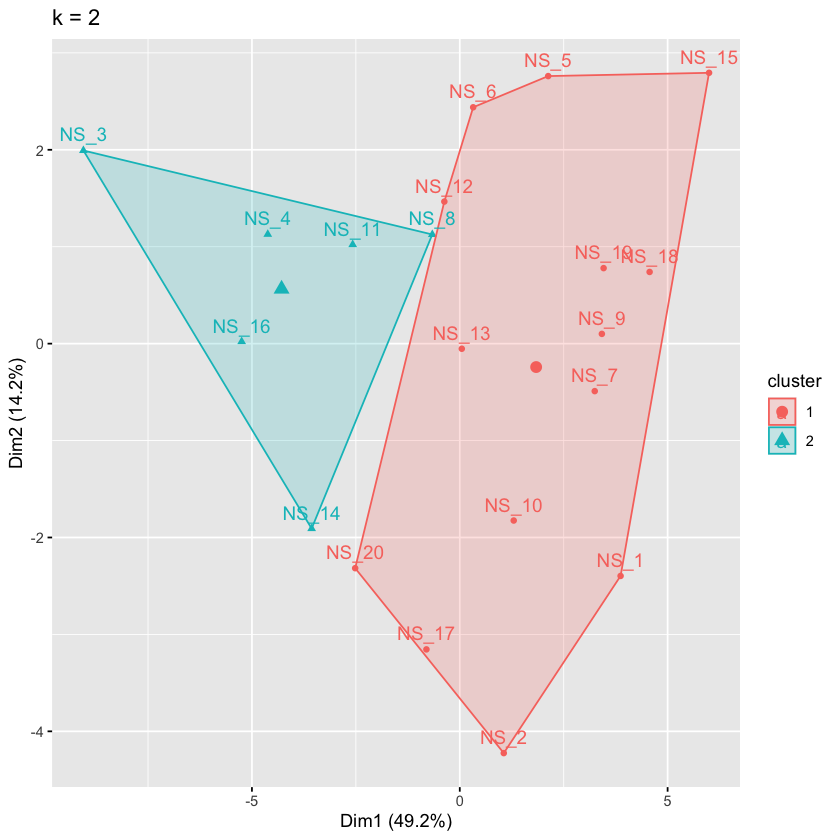

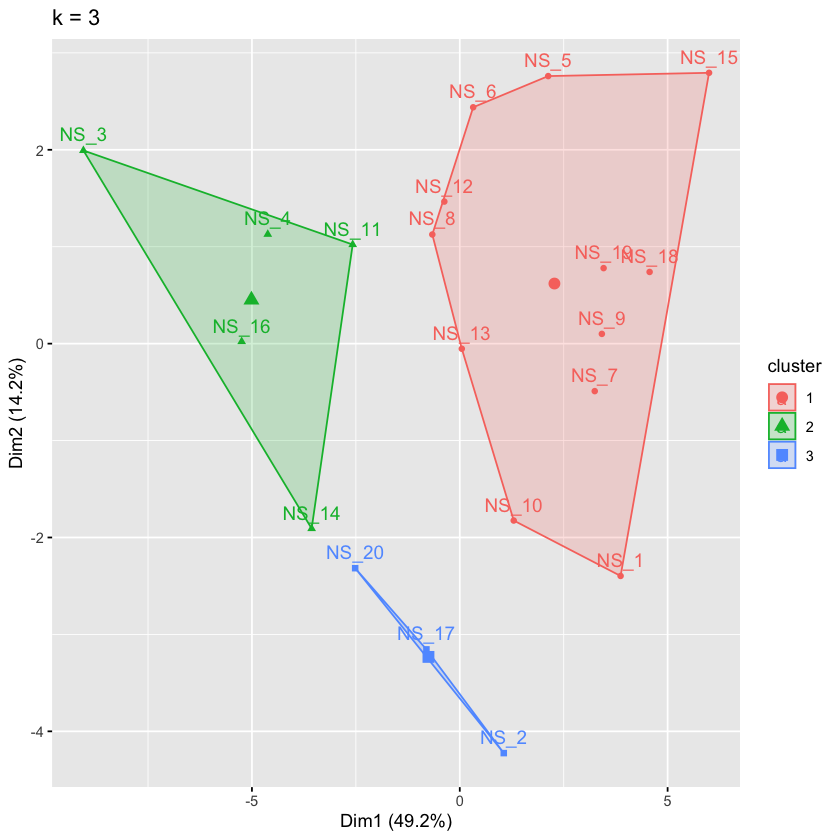

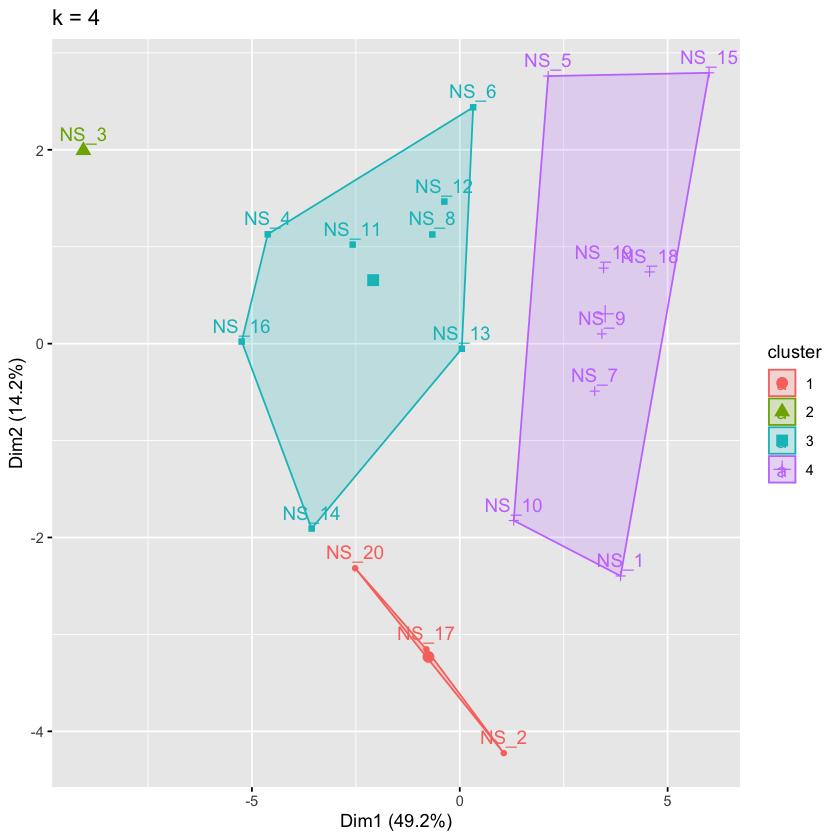

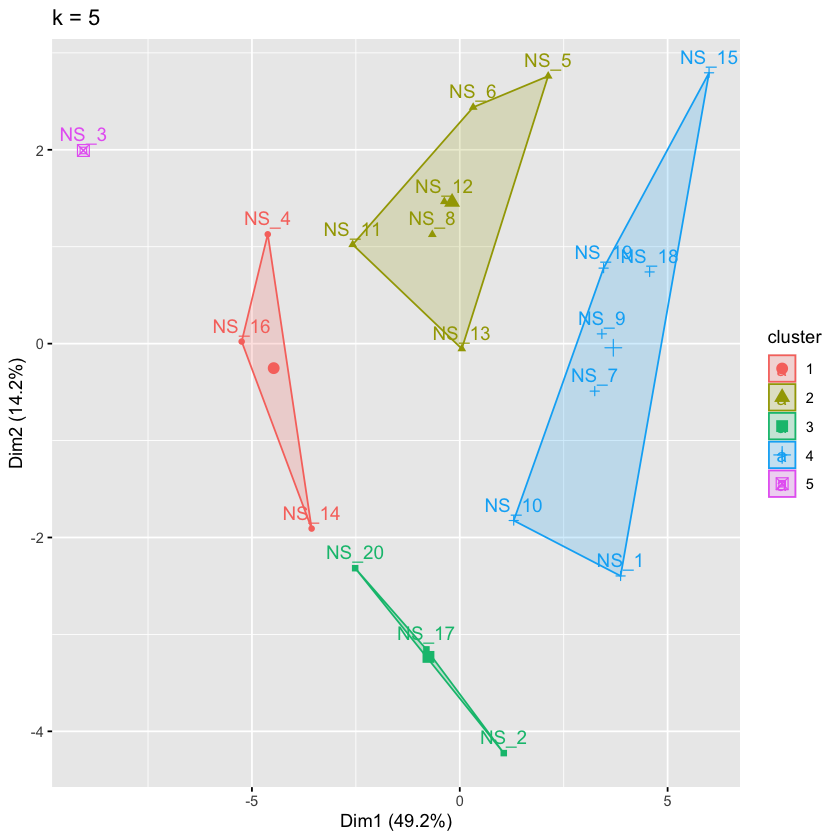

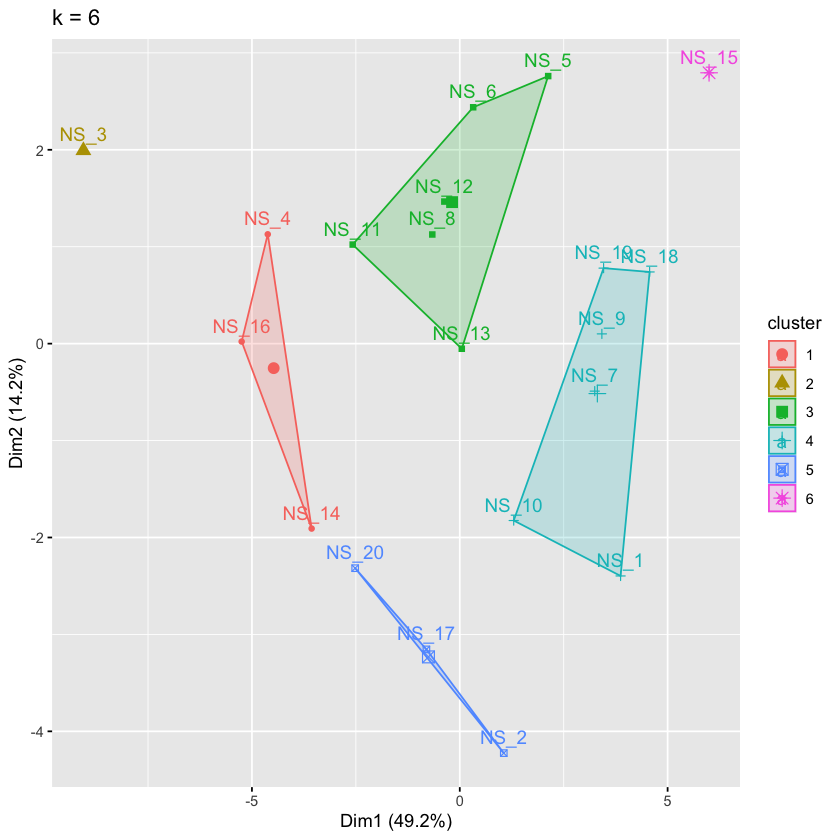

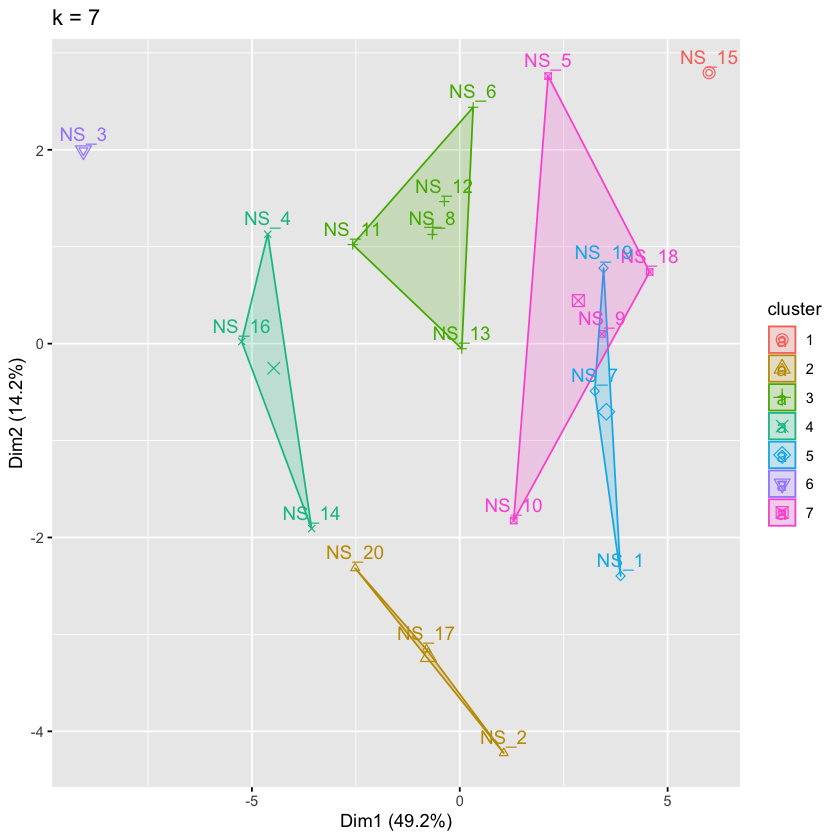

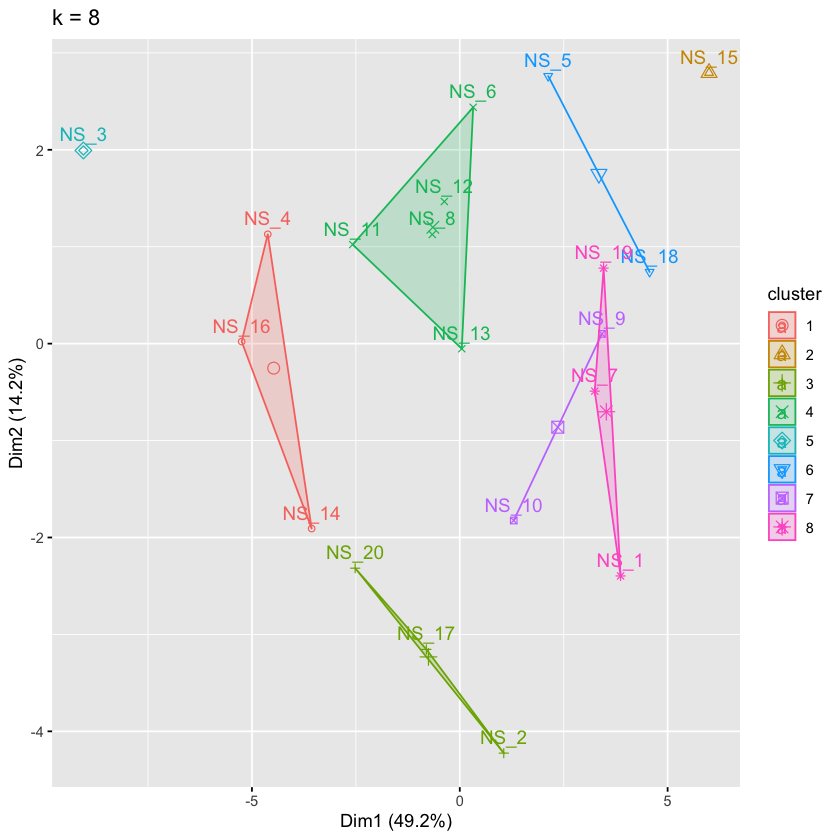

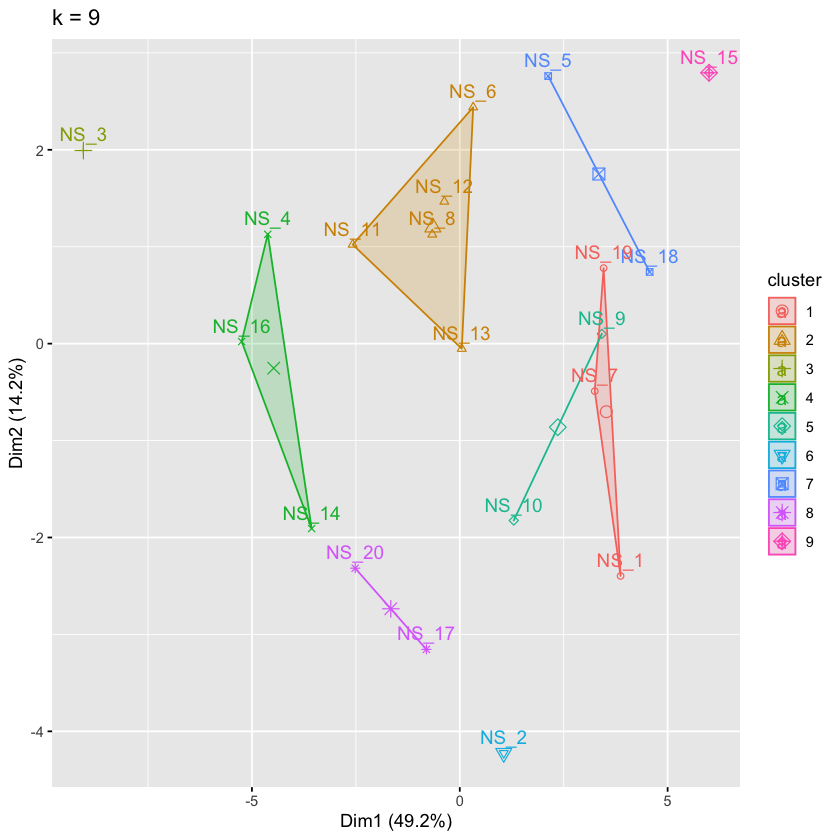

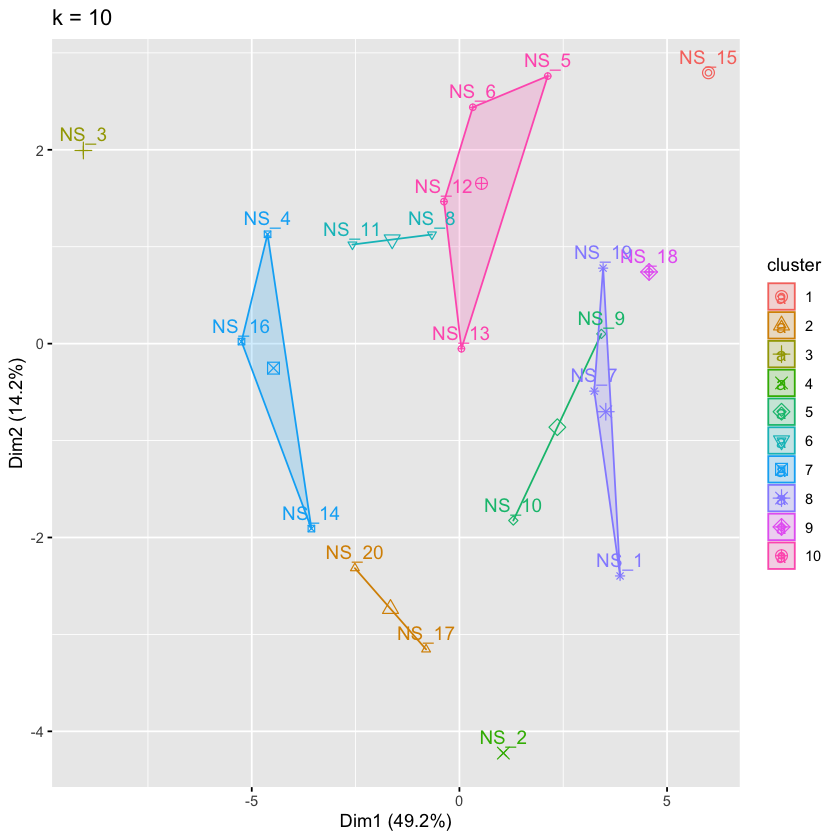

In [62]:
# Since the initial cluster assignments are random, we need to set the seed to ensure reproducibility
set.seed(151)

# Running the basic cluster analysis code
# kmeans(x, centers, iter.max = 10, nstart = 1)
# where:
#   x: numeric matrix, numeric data frame or a numeric vector
#   centers: Possible values are the number of clusters (k) or a set of initial (distinct) cluster centers. If a number, a random set of (distinct) rows in x is chosen as the initial centers.
#   iter.max: The maximum number of iterations allowed. Default value is 10.
#   nstart: The number of random starting partitions when centers is a number.
#   This means that R will try nstart different random starting assignments and then select the best results corresponding to the one with the lowest within cluster variation. The default value of nstart in R is one. But, it’s strongly recommended to compute k-means clustering with a large value of nstart such as 25 or 50, in order to have a more stable result.

# Testing different numbers of clusters (k)

cluster_plots = list()
for (i in 2:10){
    cytokines_Cluster_k <- kmeans(cytokines, centers = i, nstart = 25)
    cluster_plots[[i]] <- fviz_cluster(cytokines_Cluster_k, data = cytokines) + ggtitle(paste0("k = ",i))
    print(cluster_plots[[i]])
}
#do.call("grid.arrange", c(cluster_plots, nrow = 3))
#grid.arrange(cluster_plots[[1]],cluster_plots[[2]], cluster_plots[[3]], nrow = 3)

Estimating optimal number of clusters for cytokines.

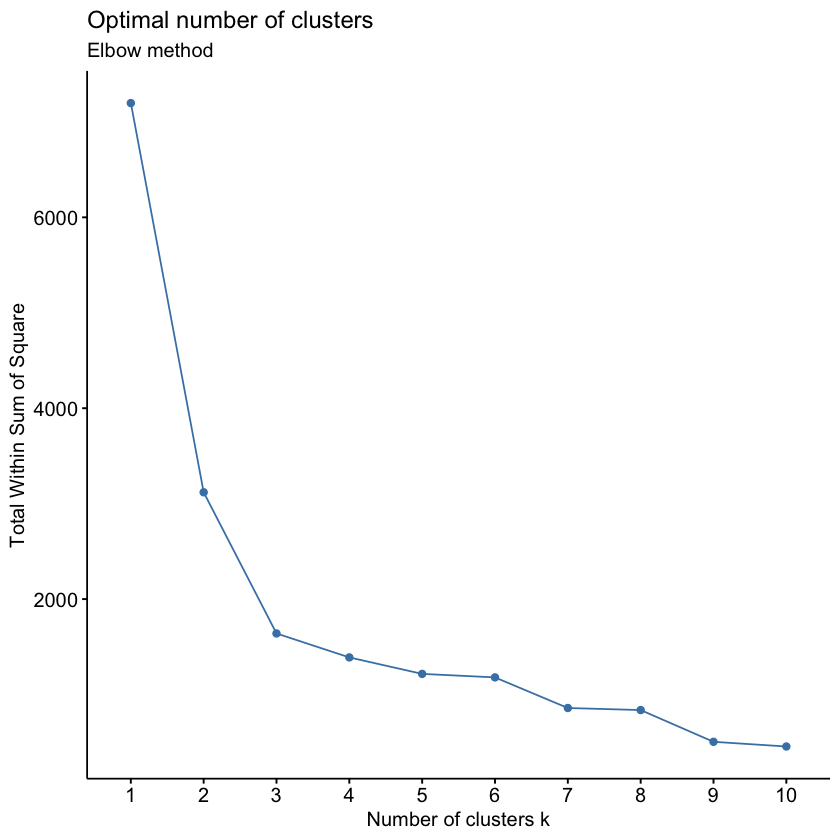

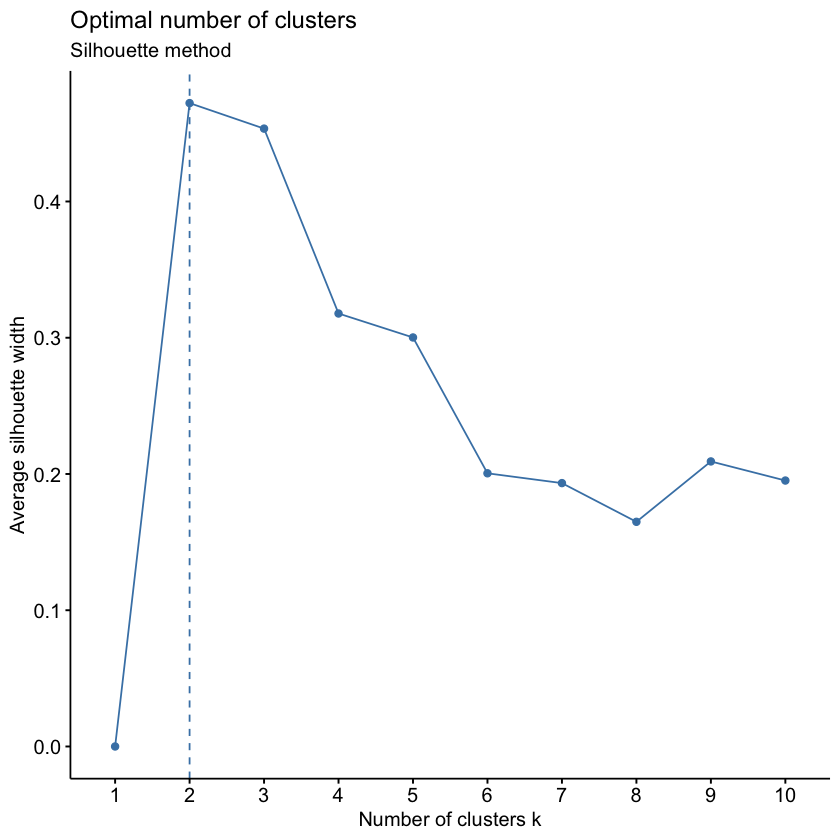

In [64]:
tcytokines = data.frame(t(cytokines))
fviz_nbclust(tcytokines, kmeans, method = "wss") +
  labs(subtitle = "Elbow method") # suggests 3
fviz_nbclust(tcytokines, kmeans, method = "silhouette") + 
  labs(subtitle="Silhouette method") # suggests 2

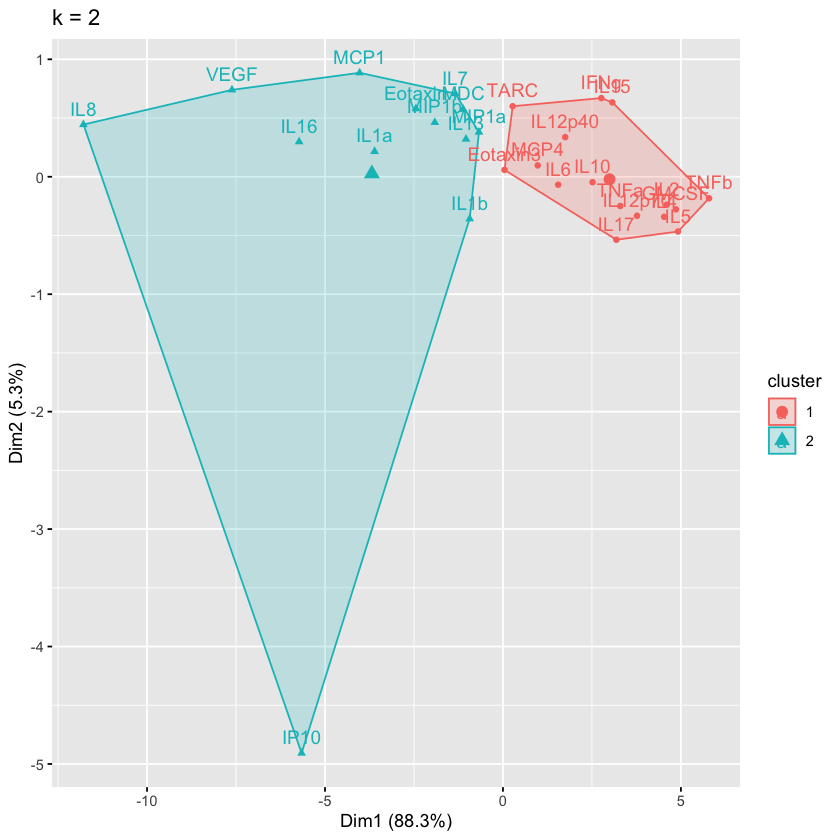

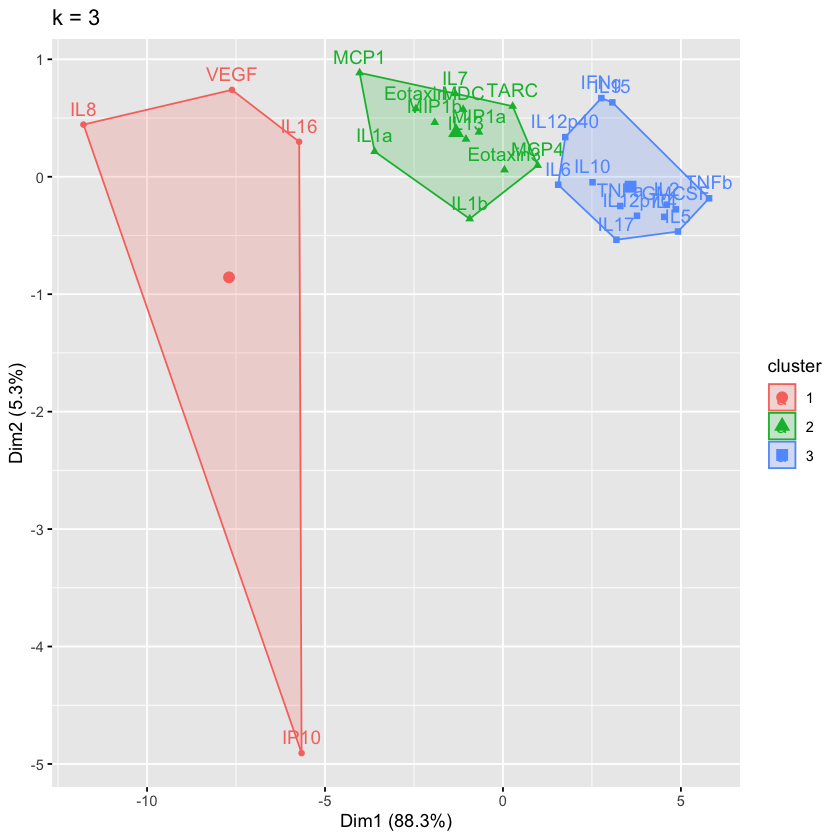

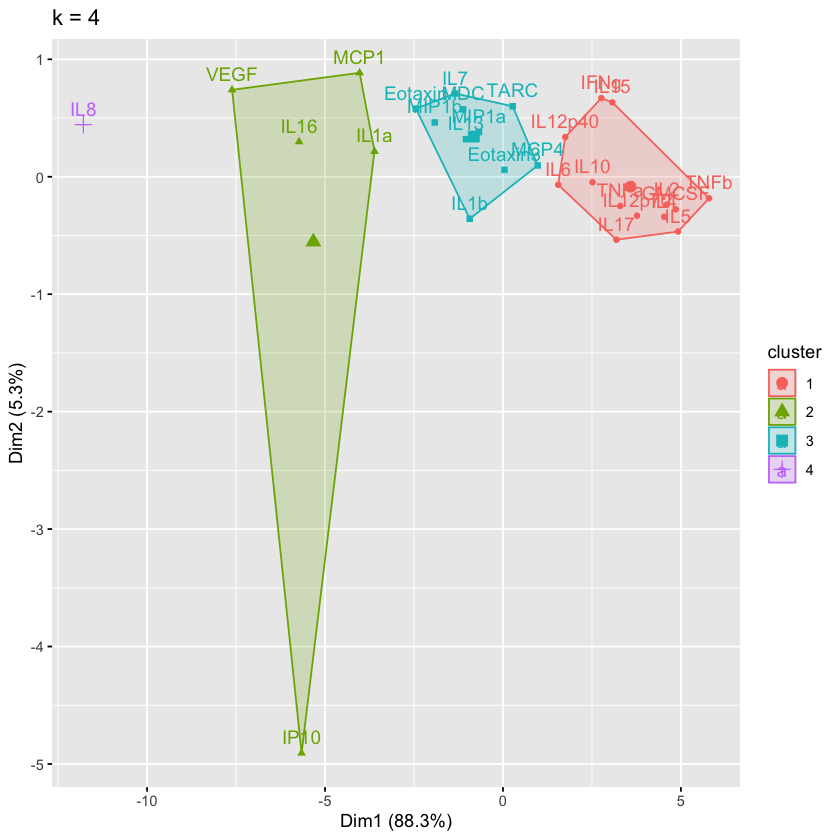

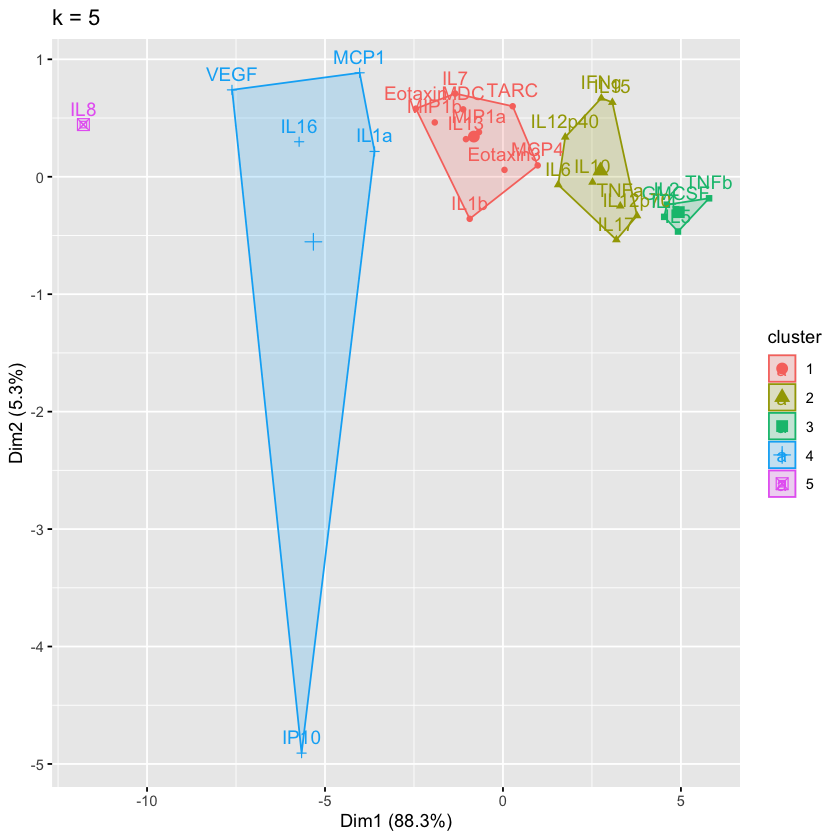

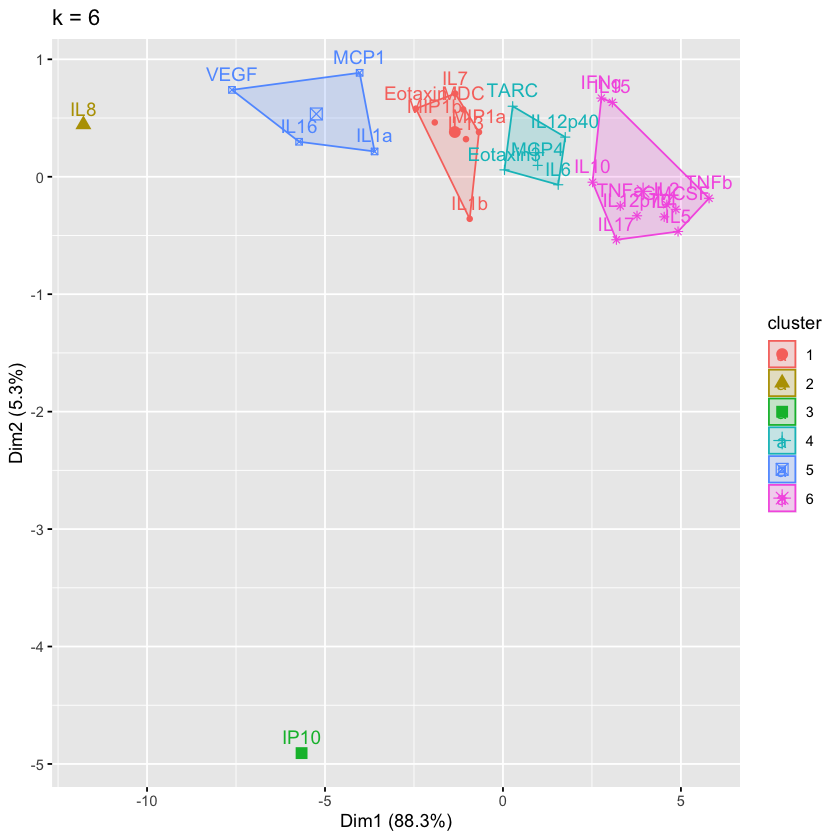

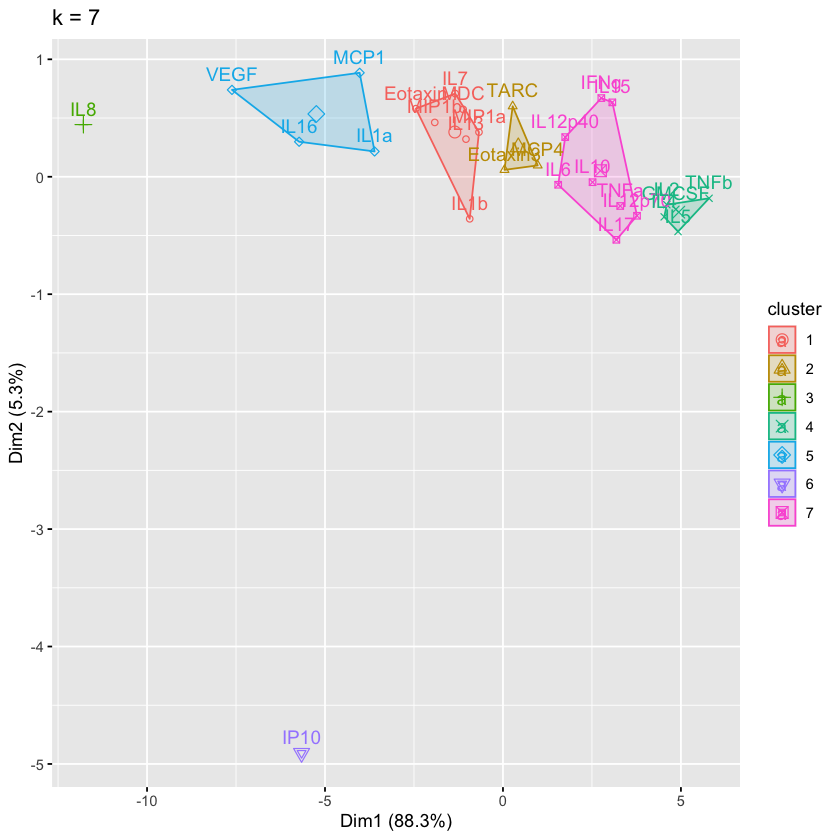

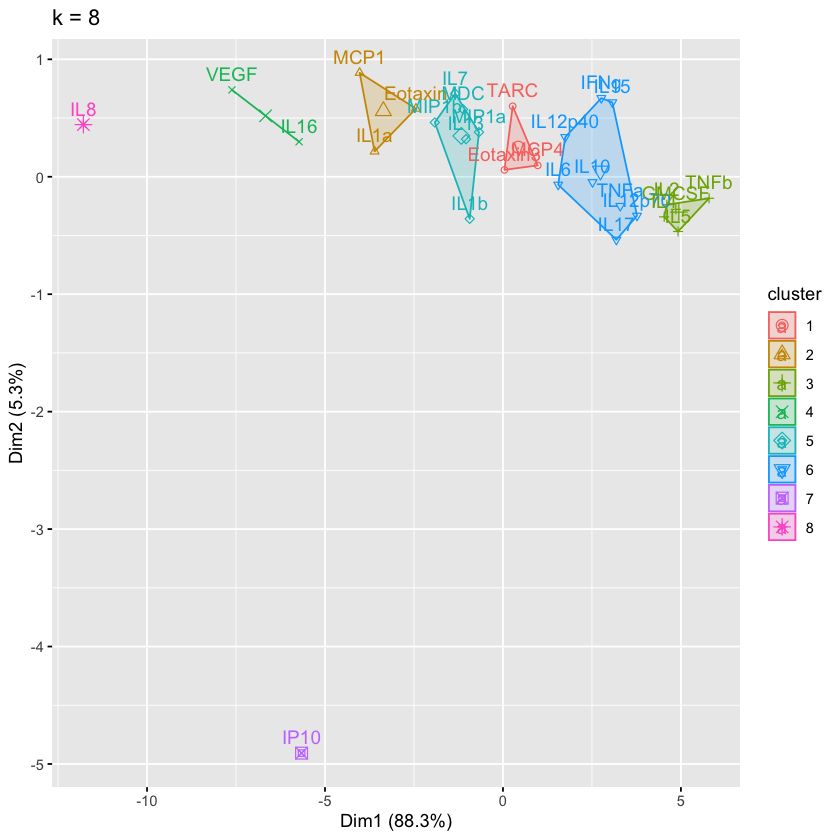

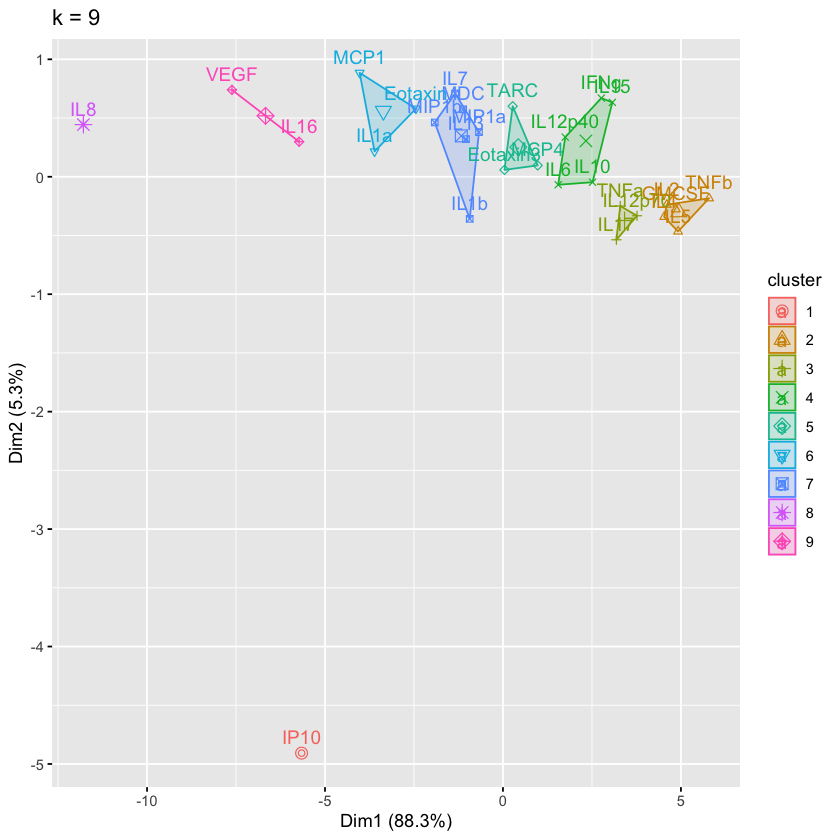

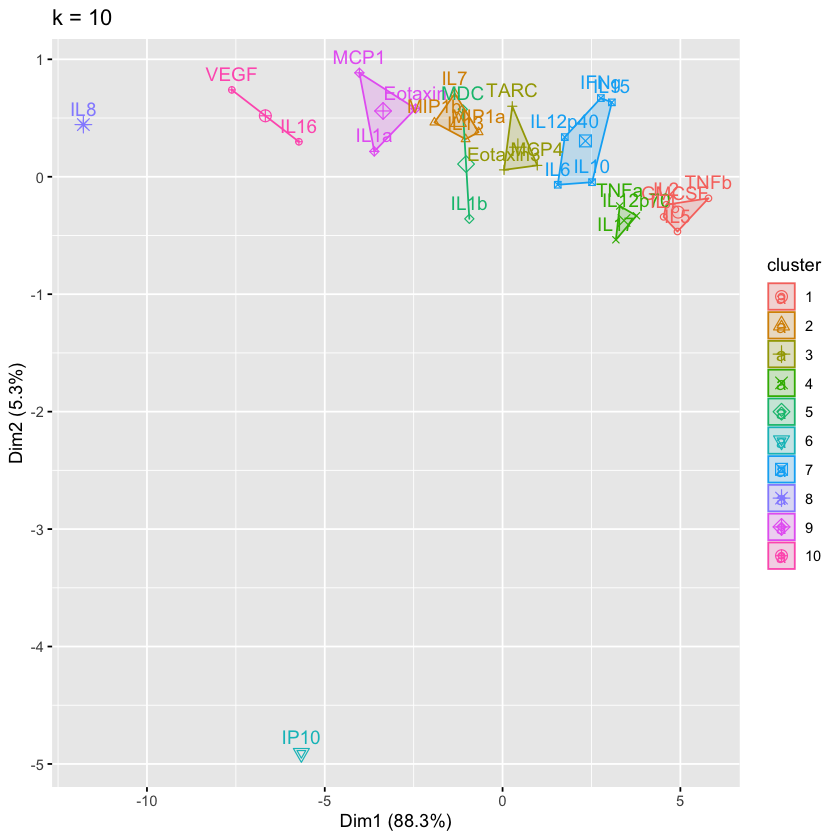

In [65]:
# Testing different numbers of clusters (k)
cluster_plots = list()
for (i in 2:10){
    cytokines_Cluster_k <- kmeans(tcytokines, centers = i, nstart = 25)
    cluster_plots[[i]] <- fviz_cluster(cytokines_Cluster_k, data = tcytokines) + ggtitle(paste0("k = ",i))
    print(cluster_plots[[i]])
    
    #
}

Since three appears to be the optimal number that will be visualized. 

# Baseline Cluster Visualization (Figure XX)

Using fviz_cluster is a bit clunky, so the results from kmeans needs to parsed in a way that ggplot will understand.

Warning message:
“ggrepel: 4 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


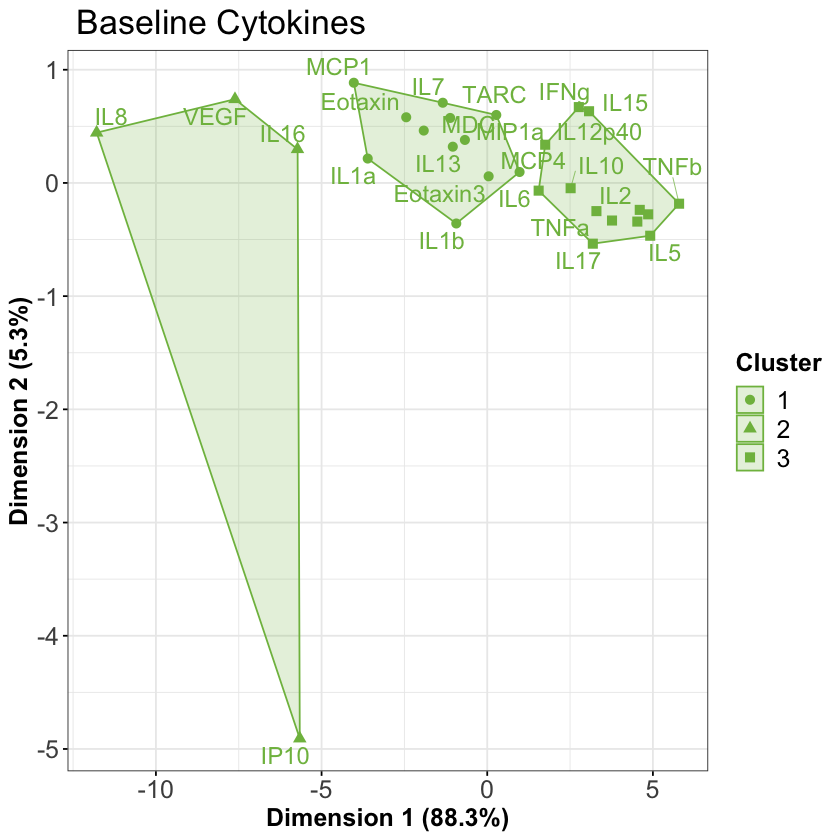

In [68]:
tcytokines_Cluster_k3 <- kmeans(tcytokines, centers = 3, nstart=25)
fviz_cluster(tcytokines_Cluster_k3, data = tcytokines, show.clust.cent = FALSE, labelsize=15, 
                      pointsize=2.5, repel=TRUE, main=" Baseline Cytokines", show.legend=F, ggtheme=theme_bw(), 
                      legend.title="Cluster") +

  scale_colour_manual(values = c("#7fbb4d", "#7fbb4d", "#7fbb4d")) +
  scale_fill_manual(values = c("#7fbb4d", "#7fbb4d", "#7fbb4d"))+

  theme(legend.text = element_text(size = 15),axis.text = element_text(size = 15), 
        axis.title.x = element_text(size=15, face="bold"), axis.title.y = element_text(size=15, face="bold"),
        title=element_text(size=17), legend.title = element_text(size=15, face="bold")) + 
        xlab("Dimension 1 (88.3%)") + 
        ylab("Dimension 2 (5.3%)")

In [72]:
trythis<-stats::prcomp(tcytokines, scale = TRUE, center = TRUE)
all_scores_df<-as.data.frame(scores(trythis))
all_scores_df$Cluster <- tcytokines_Cluster_k3$cluster
all_scores_df$Protein <- rownames(all_scores_df)

grp.1.cytokines <- all_scores_df[all_scores_df$Cluster == 1, ][chull(all_scores_df %>% filter(Cluster ==1) %>% select(PC1, PC2) ), ]  # hull values for cluster 1
grp.2.cytokines <- all_scores_df[all_scores_df$Cluster == 2, ][chull(all_scores_df %>% filter(Cluster ==2) %>% select(PC1, PC2) ), ]  # hull values for cluster 2
grp.3.cytokines <- all_scores_df[all_scores_df$Cluster == 3, ][chull(all_scores_df %>% filter(Cluster ==3) %>% select(PC1, PC2) ), ]  # hull values for cluster 3
all_hulls_df <- rbind(grp.1.cytokines,grp.2.cytokines,grp.3.cytokines)

head(all_scores_df)
head(all_hulls_df)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,Cluster,Protein
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
Eotaxin,-2.44575766,0.58005790,0.5040712,-0.19657315,-0.41353807,-0.008057245,0.04198375,-0.39047463,-0.20312867,0.420045580,⋯,-0.10557872,0.10323371,-0.03797259,0.01922371,0.04801032,-0.01658433,0.091381724,0.007661381,1,Eotaxin
Eotaxin3,0.04236238,0.05856980,1.9861643,0.73823913,0.08481523,-0.465830056,0.39631540,-0.15869951,0.12202060,-0.117120066,⋯,0.22382769,-0.07018335,0.00519653,0.03665185,0.01580915,-0.02437540,0.033303540,-0.000108651,1,Eotaxin3
GMCSF,4.85729345,-0.27729097,-0.1049390,-0.17752166,-0.27534636,0.133058377,0.14703452,0.24059698,-0.05554551,-0.081914724,⋯,-0.09635929,0.10205285,0.26114014,0.04913365,-0.11391994,0.07656720,0.056600008,0.002749291,3,GMCSF
IFNg,2.76385059,0.66991699,-0.1003811,-0.01039369,0.34403171,-0.270936462,-0.69659907,0.08291428,0.27062268,-0.255798969,⋯,0.19862368,-0.03465037,-0.03120336,-0.01088349,-0.06657814,-0.06206370,0.009255117,-0.044358693,3,IFNg
IL10,2.51686894,-0.04644268,-0.2059872,0.48406570,0.03177610,-0.199311902,0.05764477,-0.08811773,-0.22129231,-0.009722246,⋯,-0.02922696,0.05907546,-0.15105552,-0.09081882,-0.15226173,0.07219231,-0.063225304,0.015337968,3,IL10
IL12p40,1.74943758,0.33753928,-0.1404012,-0.37342809,0.02157099,-0.266856388,0.29634108,-0.28421538,0.31585576,-0.175404630,⋯,-0.32101741,0.12549008,-0.01844670,-0.09464113,0.09242328,-0.04695346,-0.081845565,-0.006595178,3,IL12p40


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,Cluster,Protein
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
MCP4,0.9758379,0.09665626,0.74231931,-0.5551057,-0.03310036,0.1919637,0.02936001,0.10379568,0.06301692,0.12975219,⋯,-0.09897106,0.03108127,-0.14048882,0.12549948,-0.051719131,-0.071468456,-0.085950077,0.043311549,1,MCP4
IL1b,-0.9346209,-0.35816567,-0.47449595,1.0766783,0.18293746,0.7906011,-0.11193883,0.20058132,0.15345957,-0.16481146,⋯,-0.01524530,0.15973789,-0.07929307,0.04794344,0.124644175,-0.056314250,0.038423080,0.004361075,1,IL1b
IL1a,-3.6074585,0.21539816,0.06028778,-0.1796723,0.04534990,0.5048367,-0.06345642,-0.03702532,-0.39740218,0.09191168,⋯,0.03458266,0.15428314,0.03021633,0.03338444,-0.001602015,-0.107951161,-0.001084638,-0.030850227,1,IL1a
MCP1,-4.0274583,0.88520021,0.09771749,-0.6009982,0.08450718,0.6257287,0.31884735,0.27957168,0.12783793,-0.21802780,⋯,0.02247281,-0.14672871,0.09084121,0.06639575,0.023773785,0.009540354,-0.051731049,0.010191168,1,MCP1
IL7,-1.3422445,0.70848287,-0.07531633,-0.8829811,-0.34667771,-0.3492191,-0.20033863,-0.02927132,-0.28451942,-0.20478067,⋯,-0.01906287,-0.13030146,-0.02870248,0.02532479,0.094937275,0.084701910,0.010782643,0.026026220,1,IL7
TARC,0.2730399,0.60037669,0.31499582,-0.4152598,-0.43755128,0.2481945,0.10884248,0.13573252,-0.04129034,0.19340791,⋯,0.17233672,-0.05594149,0.03438717,-0.02822025,-0.027587086,0.052676580,-0.046267702,-0.087301264,1,TARC


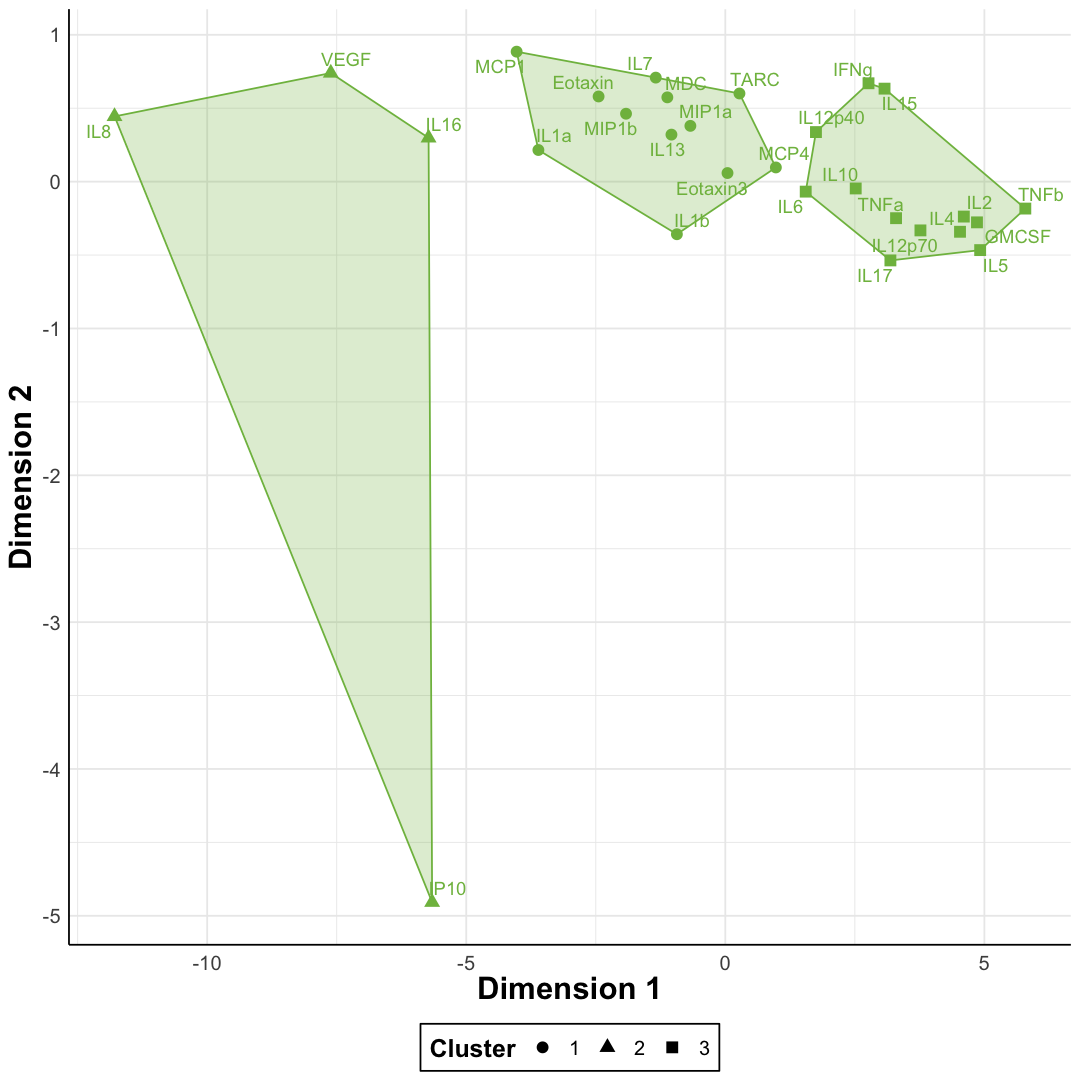

In [86]:
options(repr.plot.width=9, repr.plot.height=9) #changing size
ggplot() + 
  geom_point(data = all_scores_df, aes(x = PC1, y = PC2, color = '#7fbb4d', shape = as.factor(Cluster)), size = 3) + 
  geom_text_repel(data = all_scores_df, aes(x = PC1, y = PC2, color = '#7fbb4d', label = Protein), 
                  show.legend = FALSE) + 
  geom_polygon(data = all_hulls_df, aes(x = PC1, y = PC2, group = as.factor(Cluster), color = '#7fbb4d', 
                                        fill = '#7fbb4d'), alpha = 0.25, show.legend = FALSE) + 


  theme_minimal() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = 'bottom',
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        strip.text.x = element_text(size = 15, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 15, face = "bold")) + #changes size of facet y axis 
  xlab('Dimension 1') + ylab('Dimension 2') + #changing axis labels 
  scale_color_manual(name = 'Cluster',
                      values = c('#7fbb4d', '#7fbb4d', '#7fbb4d')) +
  scale_fill_manual(name = 'Cluster',
                      values = c('#7fbb4d', '#7fbb4d', '#7fbb4d')) +

  guides(color = FALSE, shape = guide_legend(title = "Cluster")) #removing legend for color and changing title
